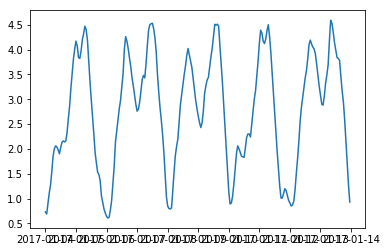

/Users/lizy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.


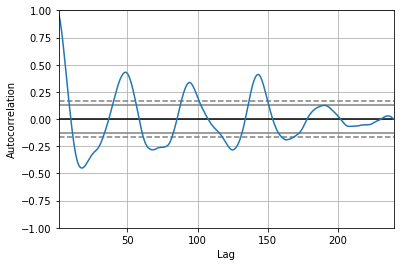

In [2]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from pandas.tools.plotting import autocorrelation_plot

def parser(x):
    return pd.datetime.strptime(x, '%d/%m/%y %H')

data = read_csv('../data/BATADAL_dataset03.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,\
                  date_parser=parser)

data2 = read_csv('../data/BATADAL_dataset04.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,\
                  date_parser=parser)

series1 = data.copy()
date = series1.index
label = series1.iloc[:,-1]

series1.index = range(len(data))
sensors = data.iloc[:,:7]


plt.figure()
a = data.iloc[:,0][:240]
plt.plot(a)
plt.show()
plt.figure()
autocorrelation_plot(a)
plt.show()


0.005880479350287628


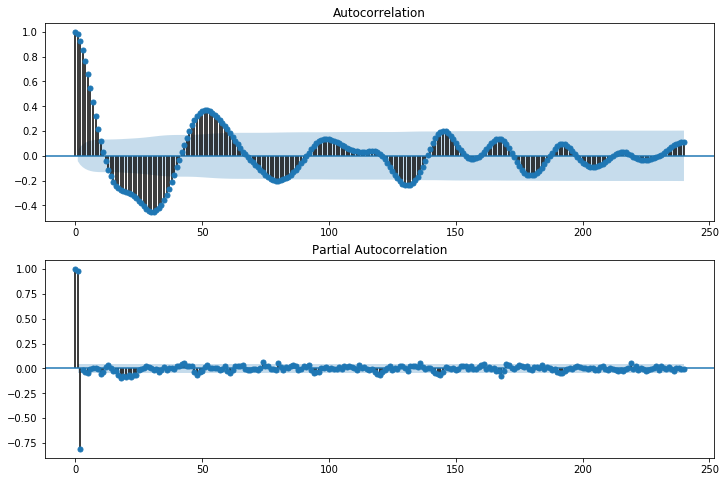

In [6]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

# show plots in the notebook
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series1.iloc[:,0].values.squeeze(), lags=240, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series1.iloc[:,0], lags=240, ax=ax2)

print(sm.stats.durbin_watson(series1.iloc[:,0]))

In [73]:
import statsmodels.api as sm

arma_mod = []
q_list=[]
p_list=[]
for idx in range(7):
    aic = []
    Mod = []
    P = []
    Q = []
    for p in range(1,4):
        for q in range(3):
            try:
                mod = sm.tsa.ARMA(data.iloc[:,idx],(p,q)).fit(disp=0)
                Mod.append(mod)
        #     print(mod.params)
                aic.append(mod.aic)
#                 print("AIC: " + str(mod.aic))
                P.append(p)
                Q.append(q)
            except:
                pass
    index_min = np.argmin(aic)
    print(index_min)
    print("optimal p,q: " + str(P[index_min])+','+str(Q[index_min]))
    arma_mod.append(Mod[index_min])
    p_list.append(P[index_min])
    q_list.append(Q[index_min])


/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7
optimal p,q: 3,2
8
optimal p,q: 3,2
8
optimal p,q: 3,2
8
optimal p,q: 3,2
5
optimal p,q: 2,2
8
optimal p,q: 3,2
5
optimal p,q: 2,2


pro: 0.052429973665310034


/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


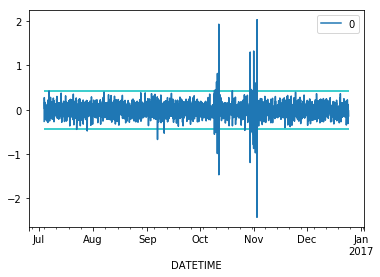

0    0.427921
Name: 0.99, dtype: float64


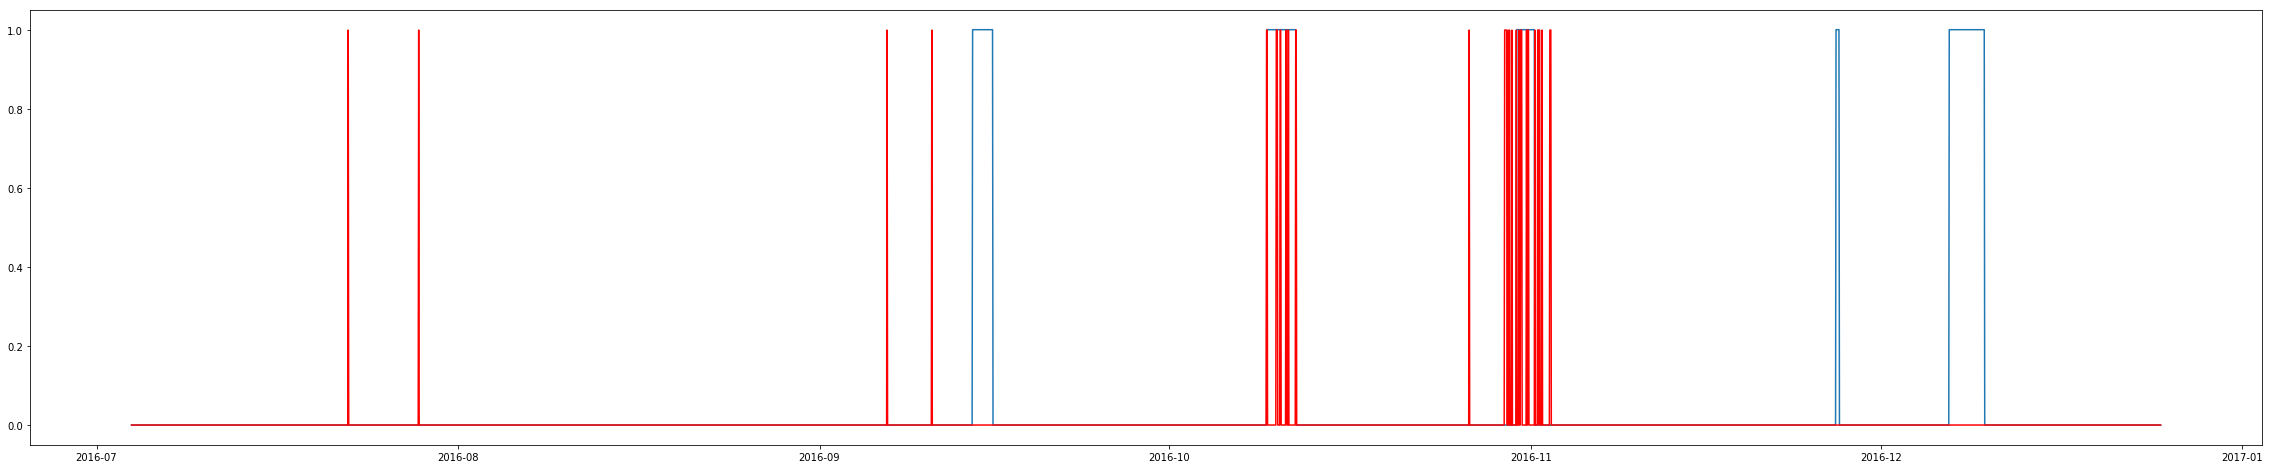

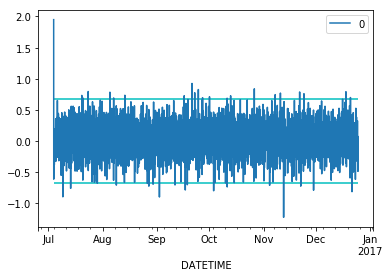

0    0.673287
Name: 0.99, dtype: float64


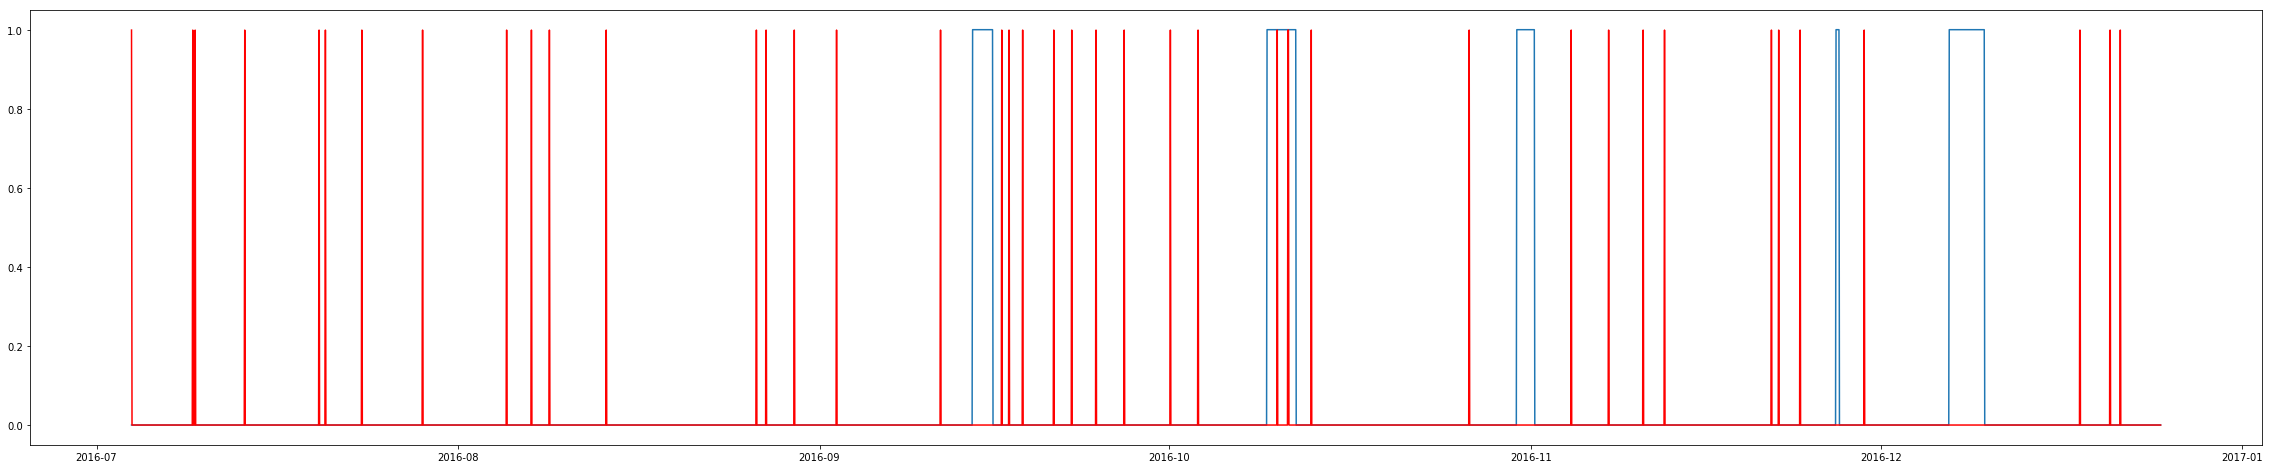

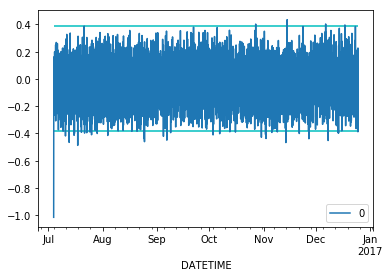

0    0.384352
Name: 0.99, dtype: float64


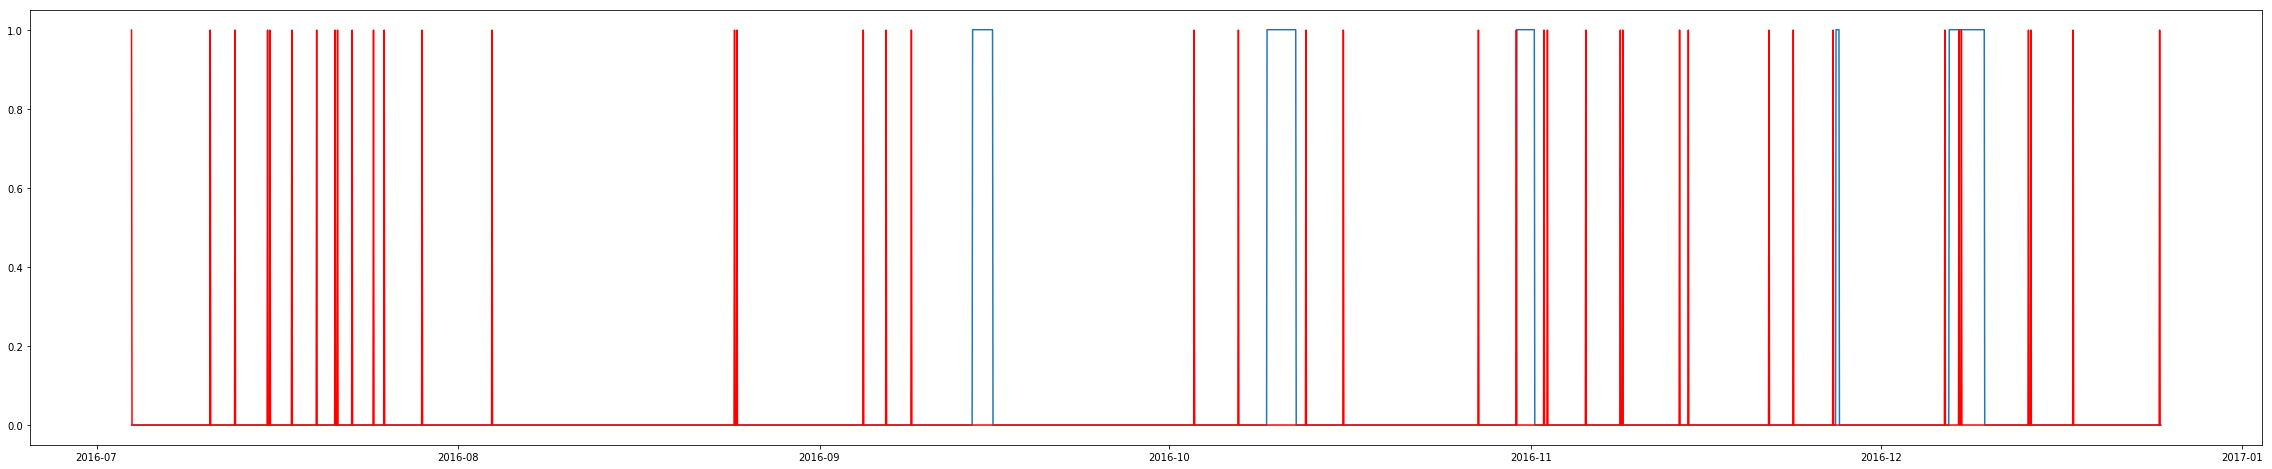

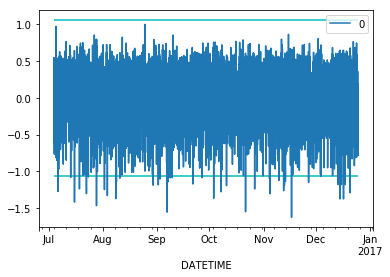

0    1.06234
Name: 0.99, dtype: float64


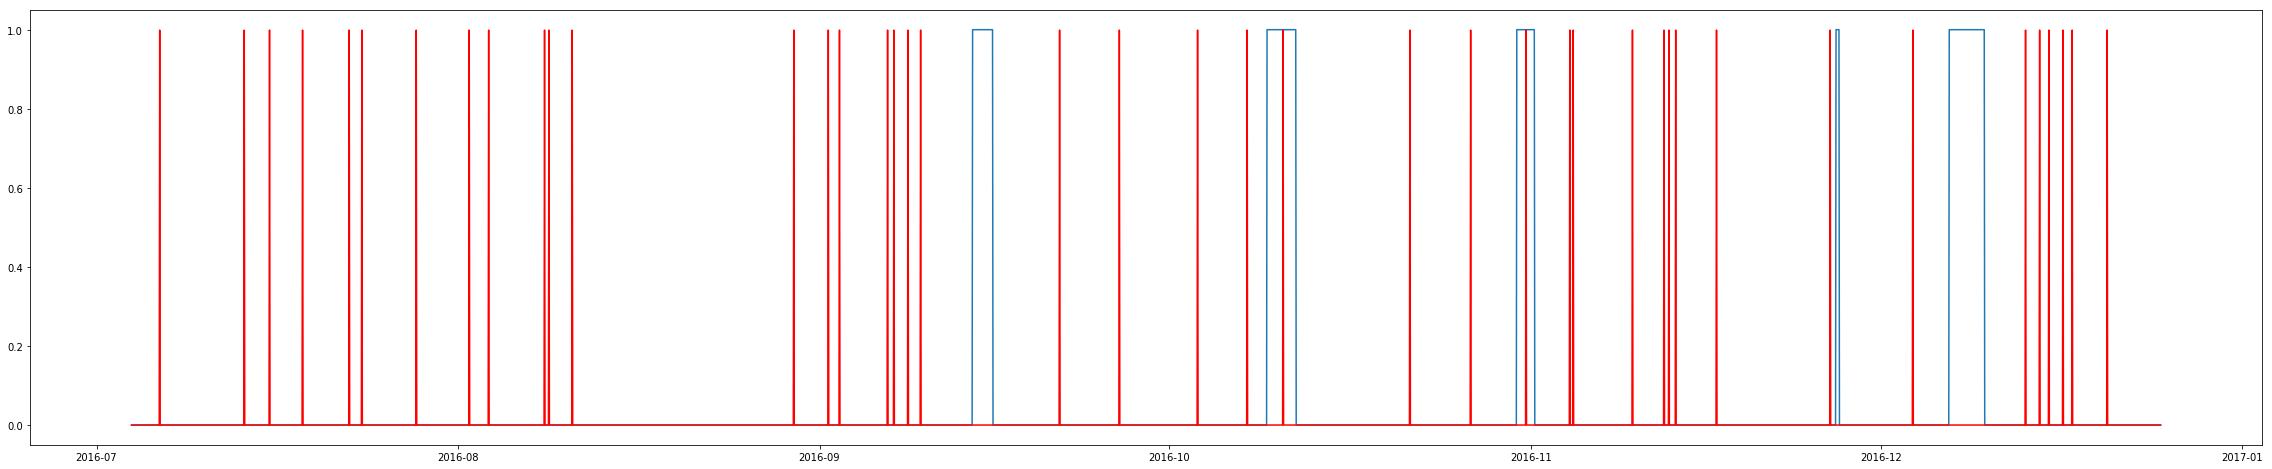

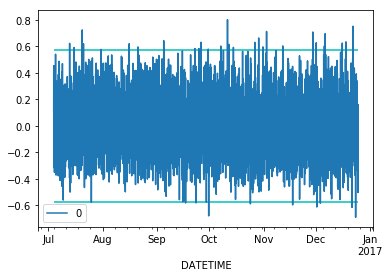

0    0.571347
Name: 0.99, dtype: float64


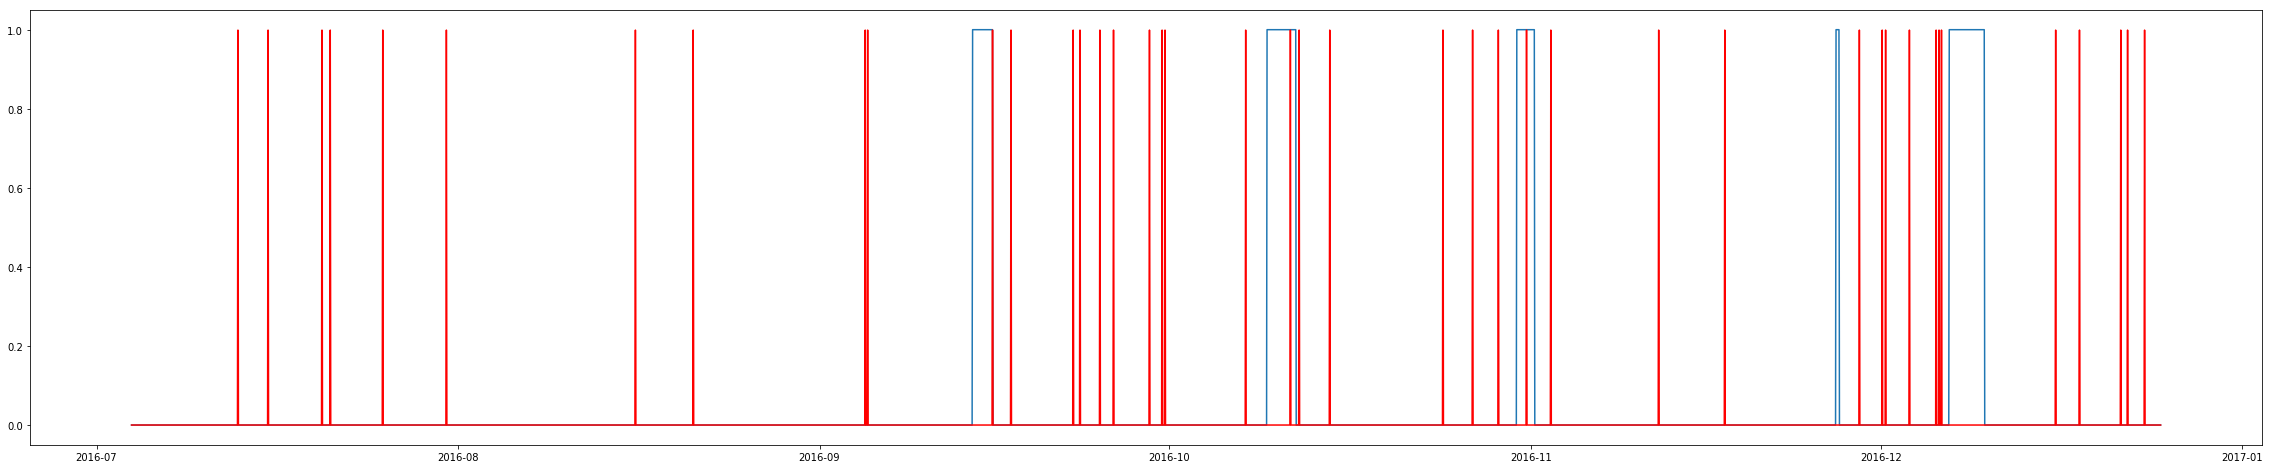

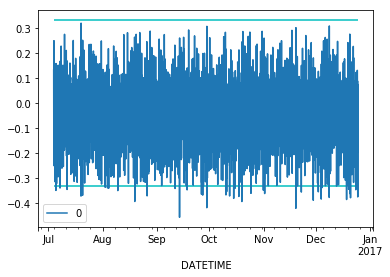

0    0.332741
Name: 0.99, dtype: float64


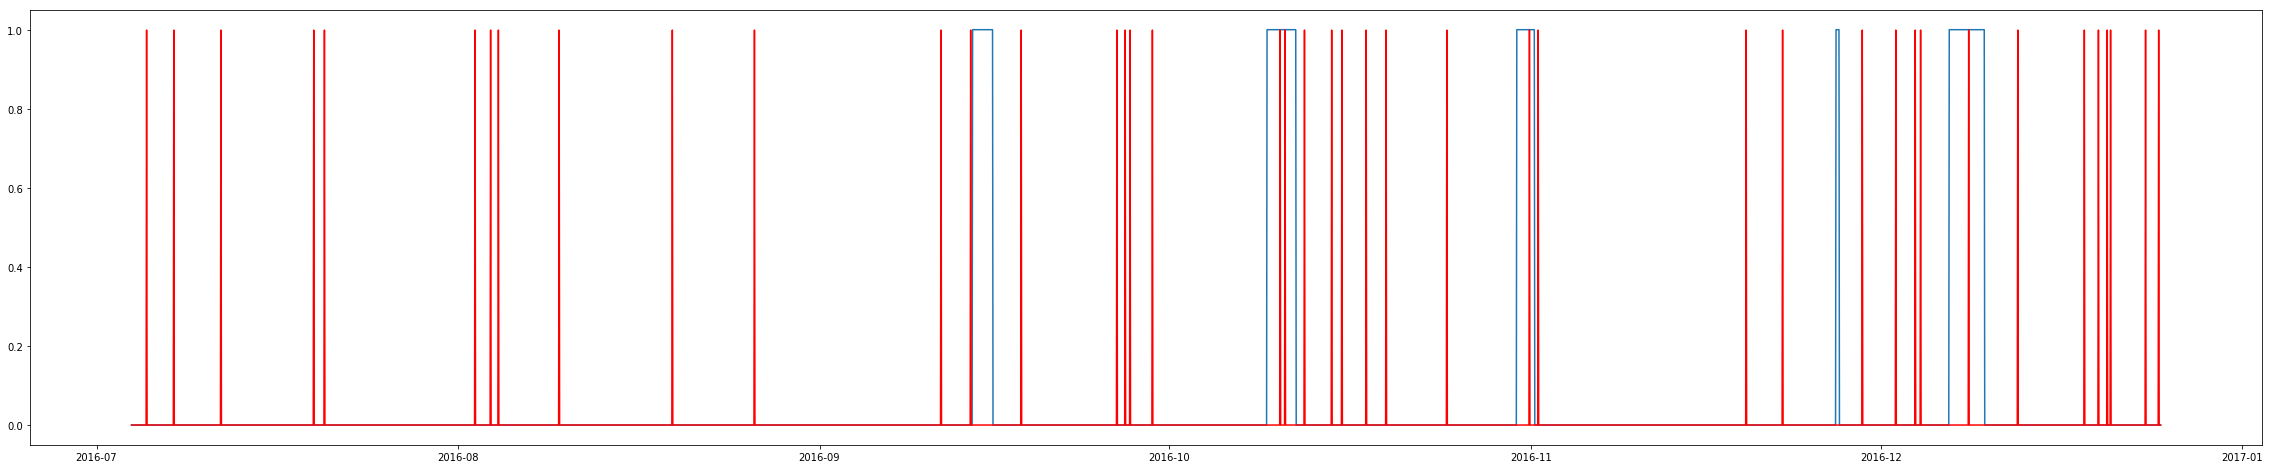

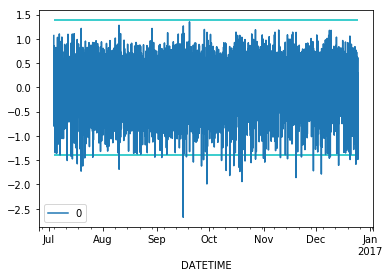

0    1.394656
Name: 0.99, dtype: float64


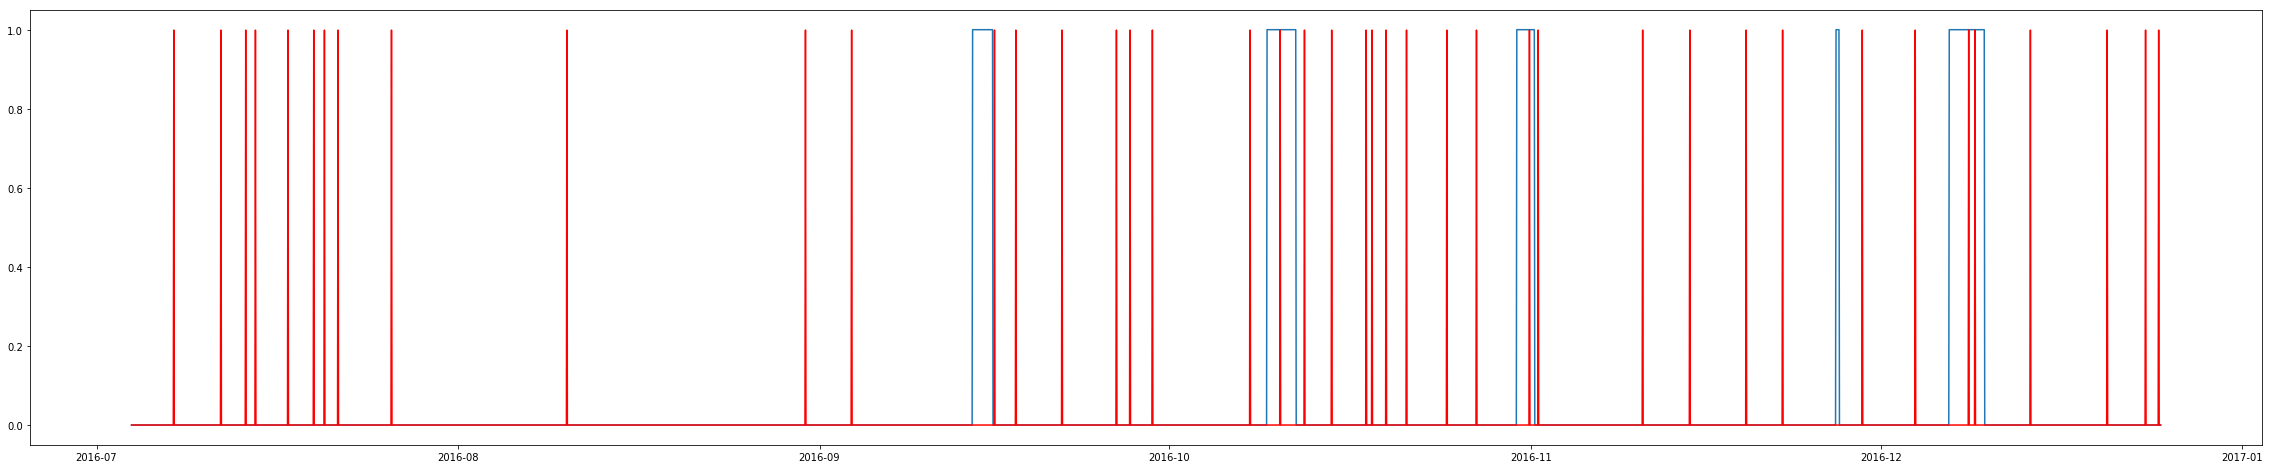

In [83]:
from pandas import DataFrame

label = data2.iloc[:,-1]
label = (label+999)/999
thres_list=[]
prediction_list = []
x = data2.index
pro = sum(label.astype(int))/len(label)
print("pro: "+str(pro))
for idx in range(7):
    # plot residual errors
    mod=sm.tsa.ARMA(data2.iloc[:,idx],(p_list[idx],q_list[idx])).fit(disp=0)
    residuals = DataFrame(mod.resid)
    residuals.plot()
    thres = abs(residuals).quantile(q=0.99)
    plt.hlines(thres, x[0], x[-1],colors = "c")
    plt.hlines(-thres, x[0], x[-1],colors = "c")
    plt.show()
    # residuals.plot(kind='kde')
    
    print(thres)
    thres_list.append(thres[0])
    
    plt.figure(figsize=(40,8))
    plt.plot(label)
    prediction=(abs(residuals)>thres[0])*1
    plt.plot(prediction, color='red')
    
    prediction_list.append(prediction)

In [84]:
from sklearn.metrics import confusion_matrix
#  true negatives  false positives
#  false negatives  true positives

recall=[]
precision=[]
for i in range(7):
    cm=confusion_matrix(prediction_list[i].astype(int),label.astype(int))
    recall.append(cm[1][1]/(cm[0][1]+cm[1][1]))
    precision.append(cm[1][1]/(cm[1][0]+cm[1][1]))

recall_max = np.argmax(recall)
precision_max = np.argmax(precision)

print(recall)
print(precision)

[0.0776255707762557, 0.0136986301369863, 0.0091324200913242, 0.0091324200913242, 0.0136986301369863, 0.0182648401826484, 0.0182648401826484]
[0.40476190476190477, 0.07142857142857142, 0.047619047619047616, 0.047619047619047616, 0.07142857142857142, 0.09523809523809523, 0.09523809523809523]


/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


0.42792080463249993


/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lizy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


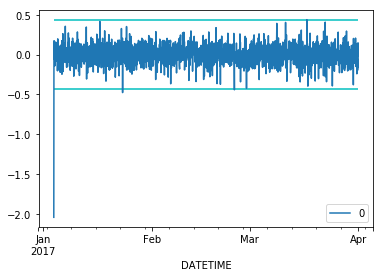

0.67328745478122


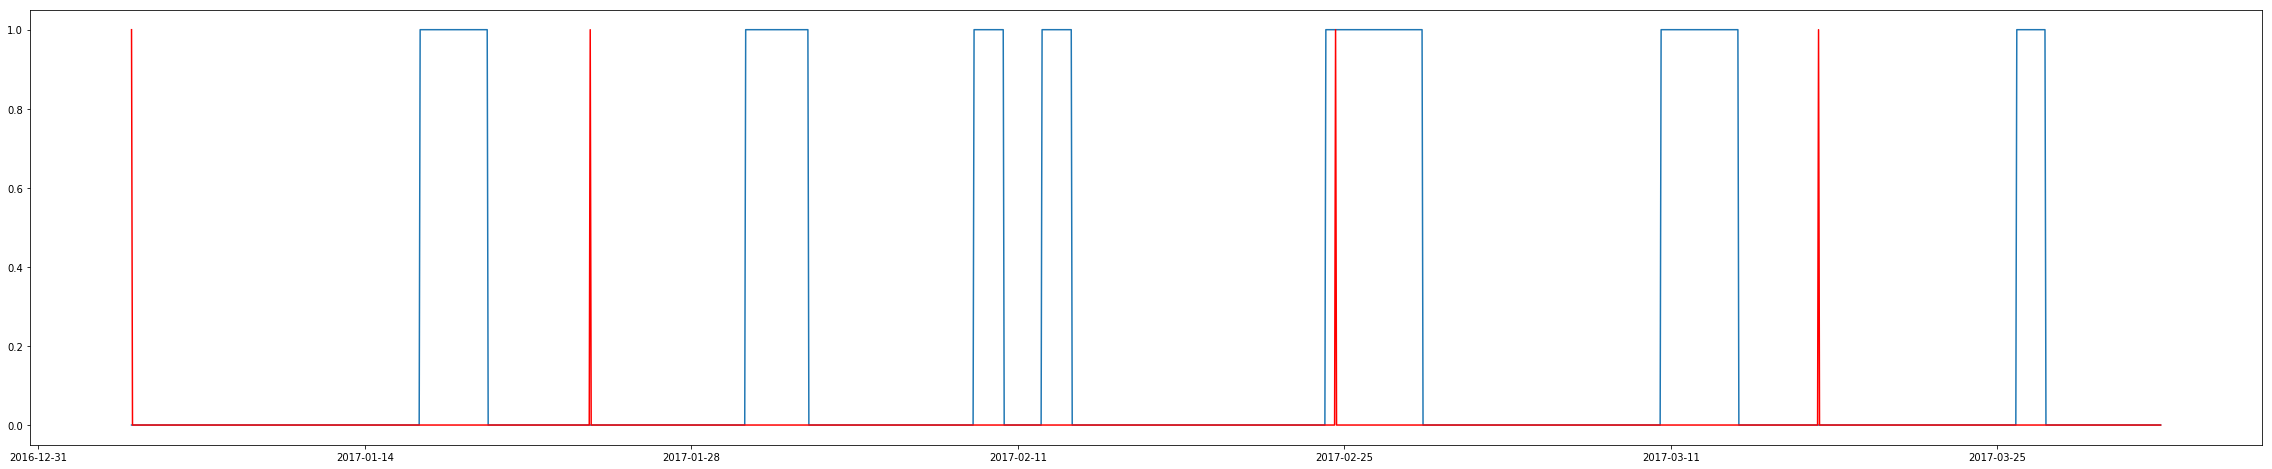

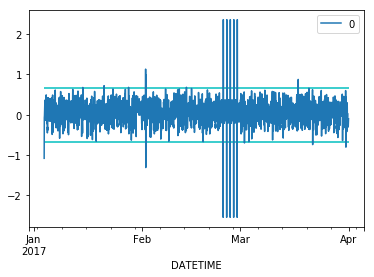

0.384352033038719


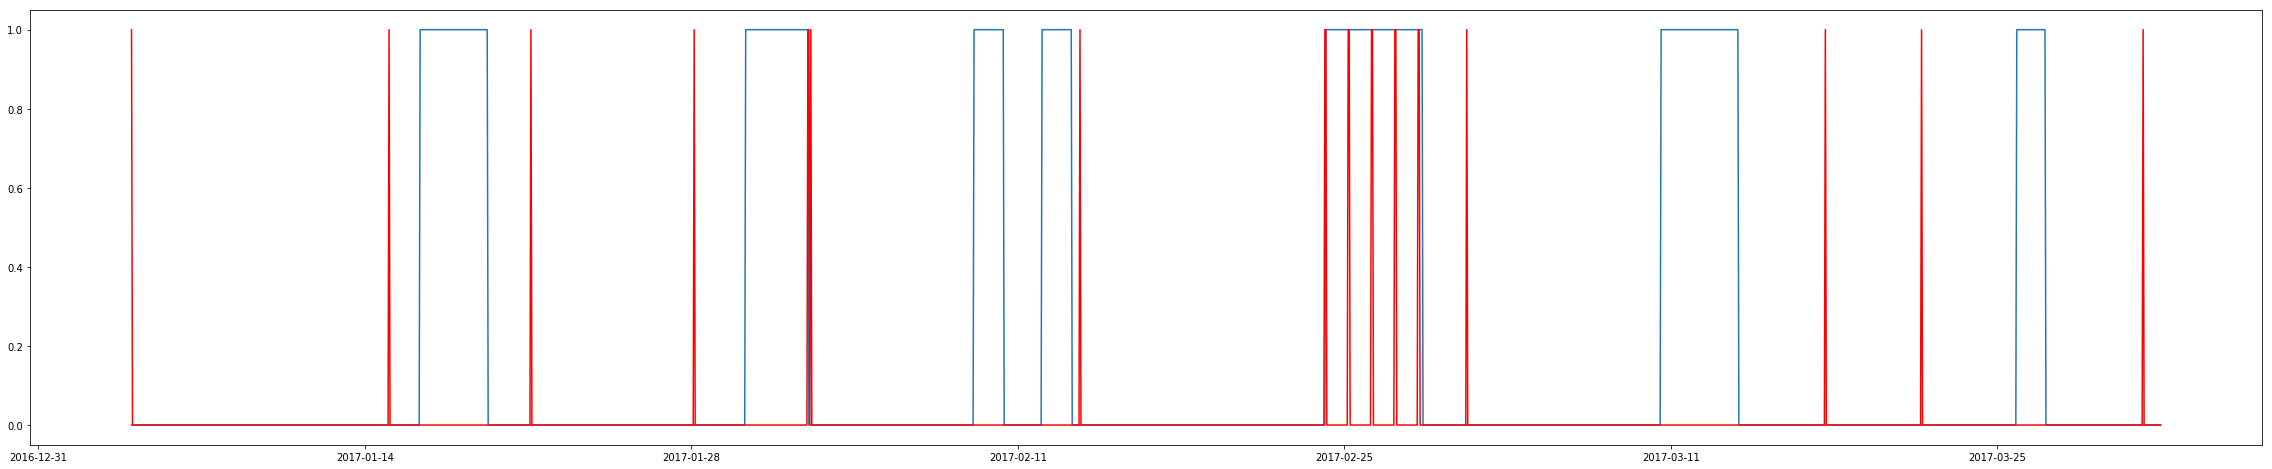

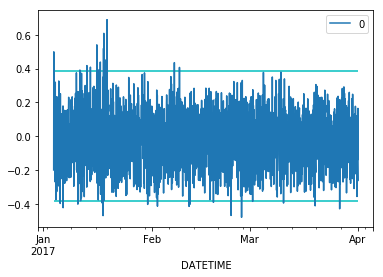

1.0623401483932358


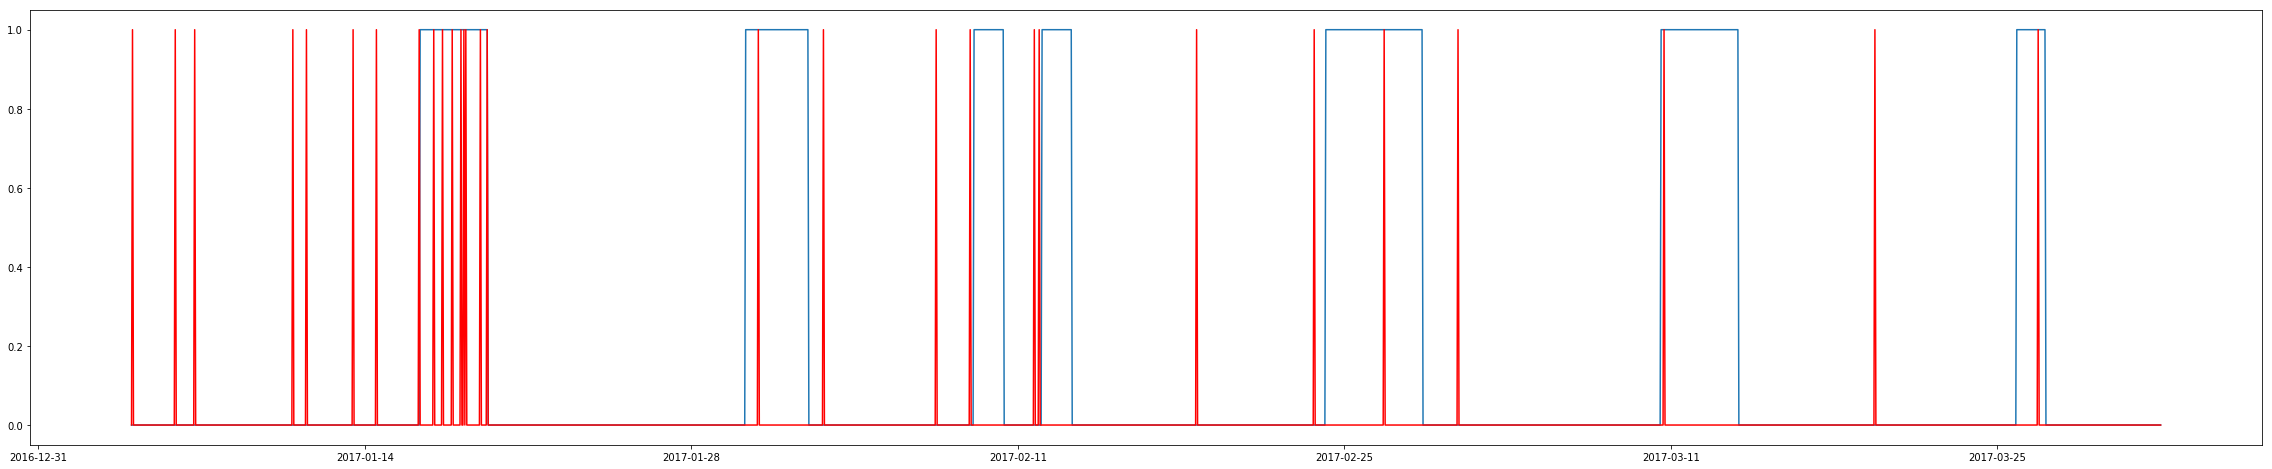

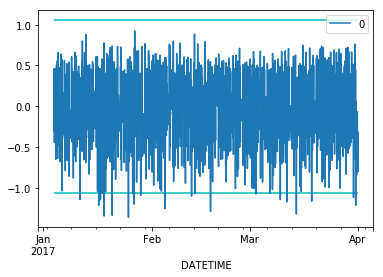

0.57134714136173


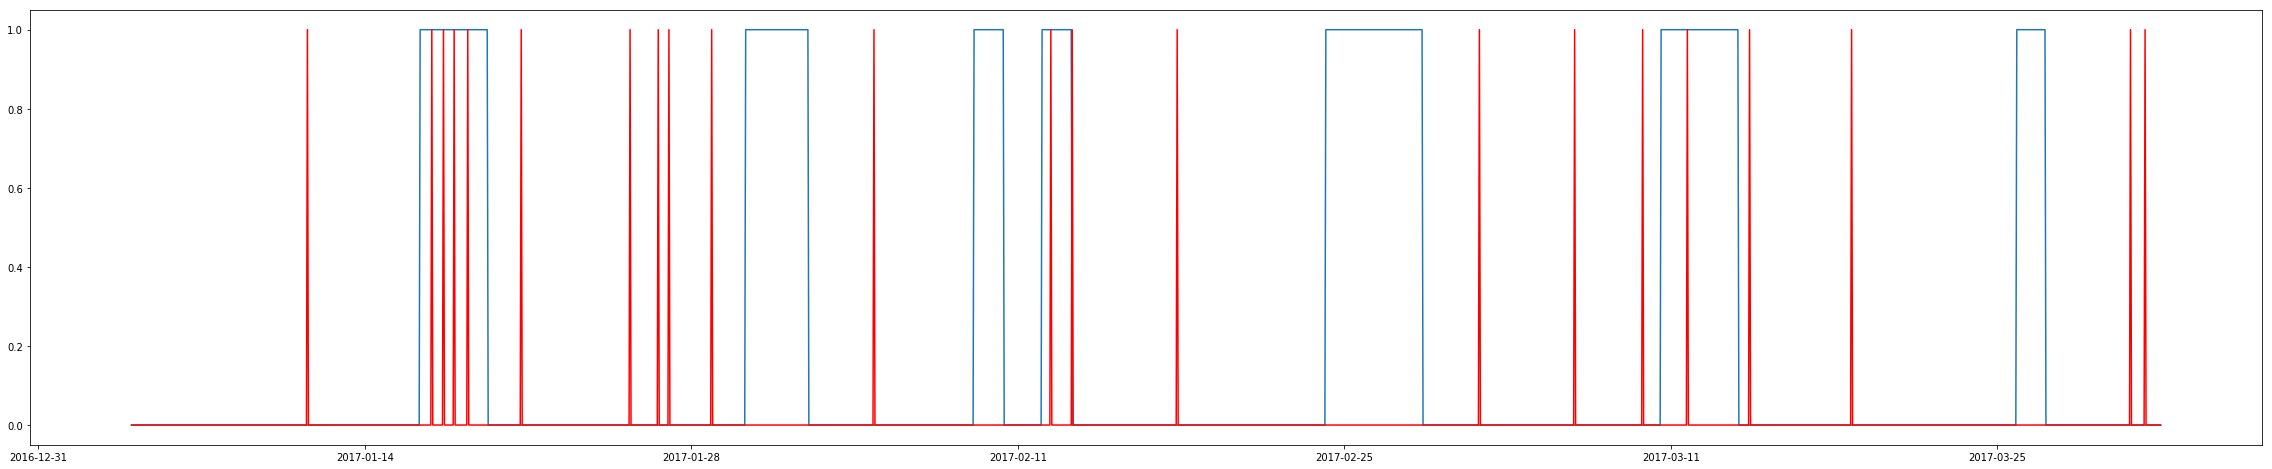

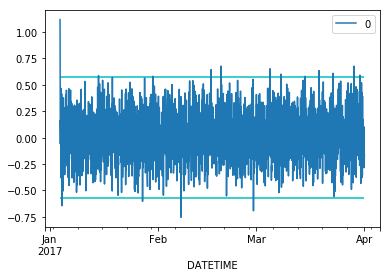

0.33274051344887634


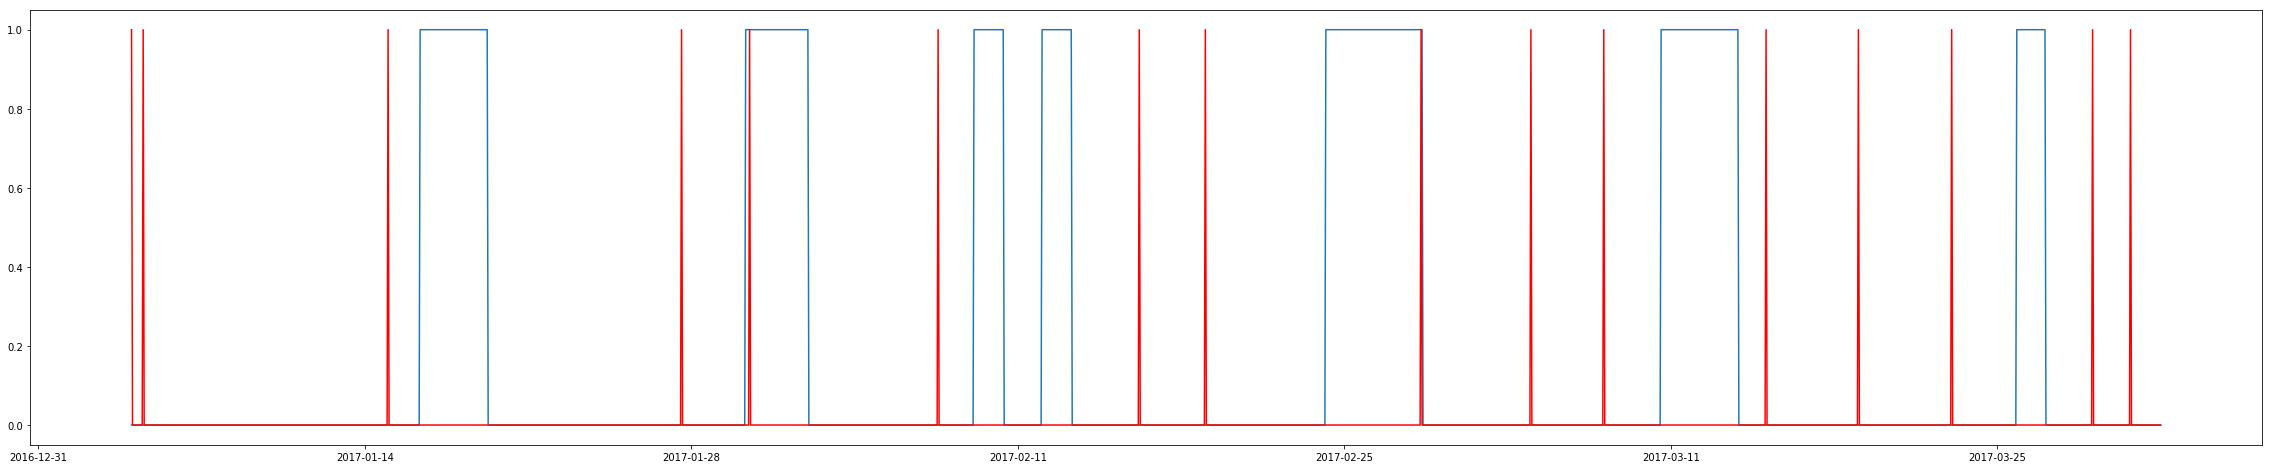

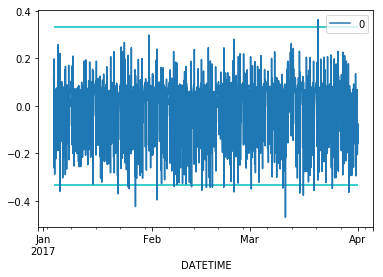

1.3946556826124883


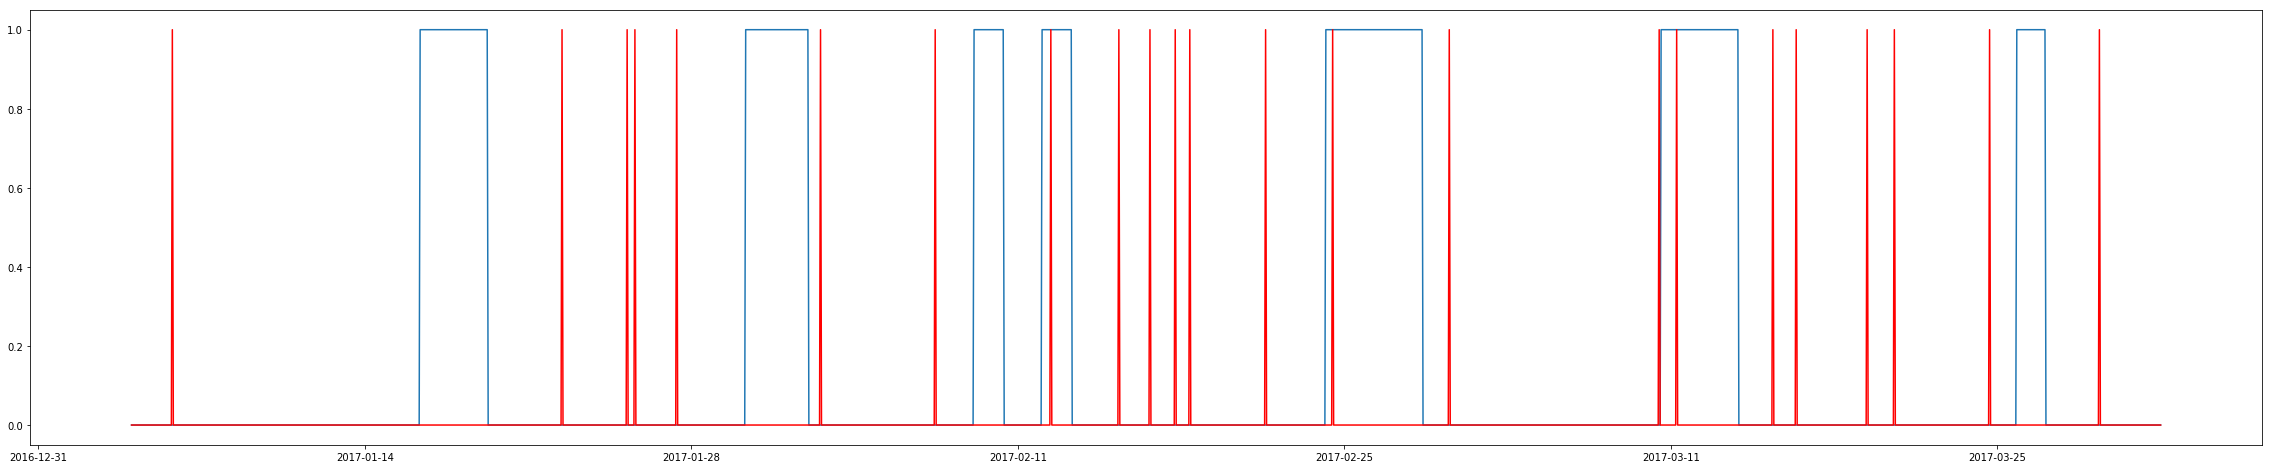

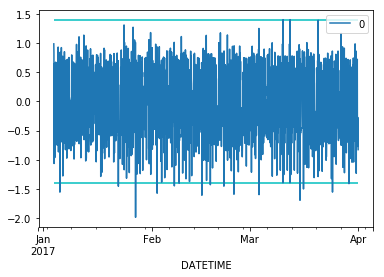

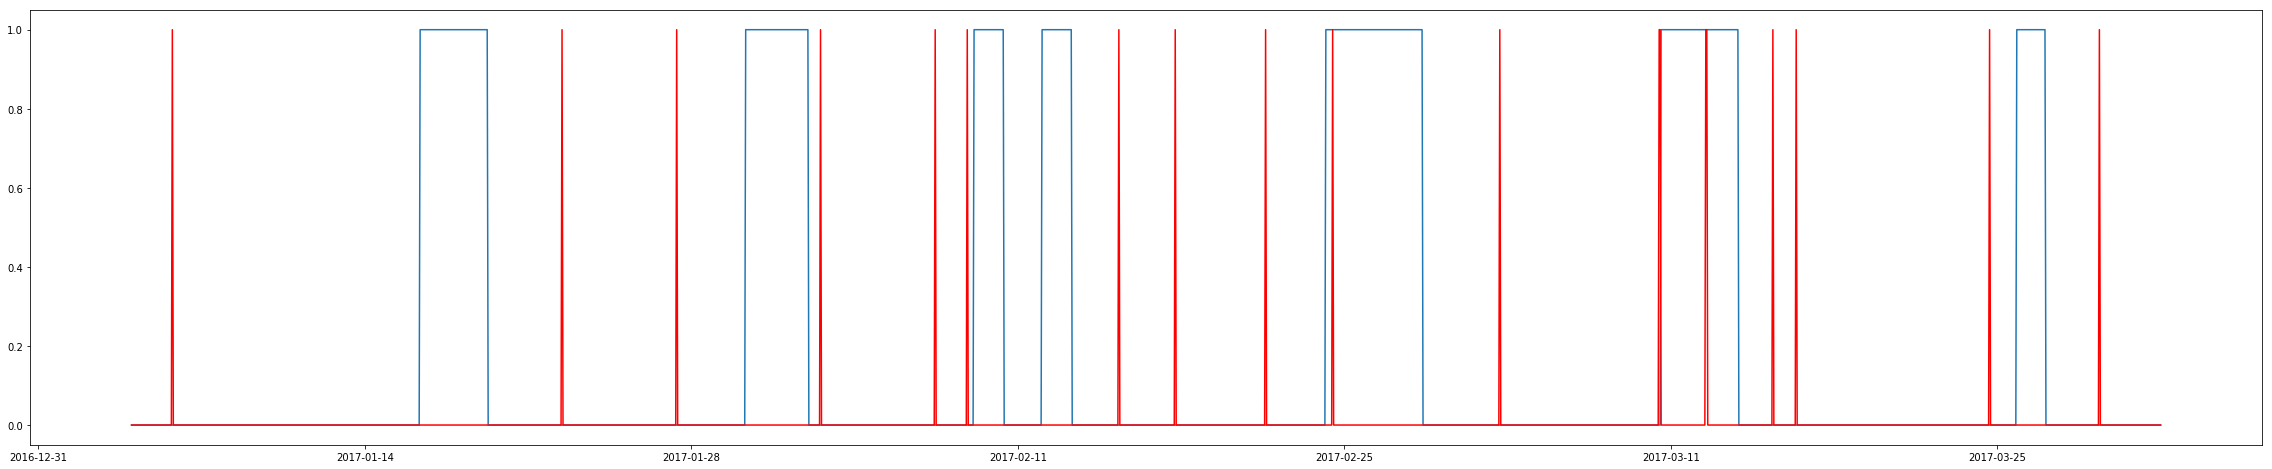

In [87]:

test_labeled = read_csv('../data/labeled_test_data.csv',sep='\t')

test = read_csv('../data/BATADAL_test_dataset.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,\
                  date_parser=parser)

from pandas import DataFrame
test_label = test_labeled['label']
prediction_test = []
x = test.index
for idx in range(7):
    # plot residual errors
    mod=sm.tsa.ARMA(test.iloc[:,idx],(p_list[idx],q_list[idx])).fit(disp=0)
    residuals = DataFrame(mod.resid)
    residuals.plot()
    thres = thres_list[idx]
    print(thres)
    plt.hlines(thres, x[0], x[-1],colors = "c")
    plt.hlines(-thres, x[0], x[-1],colors = "c")
    plt.show()
    # residuals.plot(kind='kde')
    
    plt.figure(figsize=(40,8))
    plt.plot(x,label)
    prediction=(abs(residuals)>thres)*1
    plt.plot(prediction, color='red')
    
    prediction_test.append(prediction)

In [88]:
from sklearn.metrics import confusion_matrix
#  true negatives  false positives
#  false negatives  true positives

recall_test=[]
precision_test=[]
for i in range(7):
    cm=confusion_matrix(prediction_test[i].astype(int),test_label.astype(int))
    recall_test.append(cm[1][1]/(cm[0][1]+cm[1][1]))
    precision_test.append(cm[1][1]/(cm[1][0]+cm[1][1]))

recall_max = np.argmax(recall_test)
precision_max = np.argmax(precision_test)

print(recall_test)
print(precision_test)

[0.002457002457002457, 0.02457002457002457, 0.029484029484029485, 0.014742014742014743, 0.004914004914004914, 0.007371007371007371, 0.007371007371007371]
[0.25, 0.45454545454545453, 0.41379310344827586, 0.2727272727272727, 0.125, 0.13043478260869565, 0.15789473684210525]
